In [1]:
import pyanitools as pyt
import pyaniasetools as aat
import numpy as np
import hdnntools as hdt
import os

import matplotlib.pyplot as plt

In [2]:
file_from = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files2/'
file_to = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files2_fix/'
file_xyz = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/h5files2_fix/'

wkdir = '/home/jujuman/Research/DataReductionMethods/h5_stats_check/ANI-AL-0707.0001.0410'
#wkdir = '/home/jujuman/Research/ANI-validation/'
cnstfile = wkdir + '/train0/rHCNOSFCl-4.6A_16-3.1A_a4-8.params'
saefile  = wkdir + '/train0/sae_wb97x-631gd.dat'
nnfdir   = wkdir + '/train'
Nn = 5

In [3]:
files = os.listdir(file_from)
files.sort()

# Define the conformer cross validator class
anicv = aat.anicrossvalidationconformer(cnstfile,saefile,nnfdir,Nn,0,False)

In [4]:
pae = [] 
gidx_l = []
err_l = []
err_c = []
for k,f in enumerate(files):
    print('Working on file:',f)
    adl = pyt.anidataloader(file_from+f)

    # Data storage
    dpack = pyt.datapacker(file_to+f)

    for i,data in enumerate(adl):
        #if i == 2:
        #    break
        X = data['coordinates']
        S = data['species']
        Edft = hdt.hatokcal * data['energies']
        path = data['path']
        del data['path']
    
        #print(Edft.shape, X.shape)
        if X.shape[0] != 0:
    
            Eani, Fani = anicv.compute_energy_conformations(X=np.array(X,dtype=np.float32),S=S)
    
            Eani_m = np.mean(Eani, axis=0)
            #Fani = np.mean(Fani, axis=0)
    
            dE = Eani - Edft
            err = Eani_m - Edft 
        
            err_l.append(err/np.sqrt(float(len(S))))

            gidx = []
            for j,row in enumerate(dE.T):
                Nfail = np.where(np.abs(row/np.sqrt(len(S))) > 3.0)[0].size
                if Nfail >= 4:
                    print('1:(',str(k).zfill(3),str(i).zfill(3),str(j).zfill(3),')',len(S),err[j],(Eani.T[j]-Edft[j])/np.sqrt(len(S)),Edft[j]/hdt.hatokcal)
                    x = X[j].reshape(1,X.shape[1],3)
                    hdt.writexyzfile(file_xyz+"check_"+str(k).zfill(3)+str(i).zfill(3)+str(j).zfill(3)+".xyz",x,S)
                elif Nfail < 4 and np.abs(err[j]/np.sqrt(len(S))) > 8.0:
                    print('2:(',str(k).zfill(3),str(i).zfill(3),str(j).zfill(3),')',len(S),err[j],(Eani.T[j]-Edft[j])/np.sqrt(len(S)),Edft[j]/hdt.hatokcal)
                    x = X[j].reshape(1,X.shape[1],3)
                    hdt.writexyzfile(file_xyz+"check_"+str(k).zfill(3)+str(i).zfill(3)+str(j).zfill(3)+".xyz",x,S)
                else:
                    gidx.append(j)
            gidx_l.append(np.array(gidx))      
            #klist = ['cm5', 'hirshfeld', 'hirdipole', 'forces', 'coordinates', 'spindensities', 'energies']
            klist = ['CM5', 'hirshfeld', 'forces', 'coordinates', 'energies']

            err_c.append(err[gidx]/np.sqrt(float(len(S))))
            data_new = data.copy()
            for key in klist:
                data_new[key] = data[key][gidx]
                #print(key,type(data[key][0]),type(data_new[key][0]),type(data[key][gidx][0]))
            
            dpack.store_data(path, **data_new)
print('done')
dpack.cleanup()
err_l = np.concatenate(err_l)
err_c = np.concatenate(err_c)

Working on file: dimers1.h5
1:( 000 023 116 ) 6 -11.1236009404 [-3.679276   -6.88989411 -4.76594701 -3.13987143 -4.23096678] -220.05012618
1:( 000 030 239 ) 8 -13.9380798919 [-6.30025893 -5.33755501 -4.69472755 -5.36726552 -2.93947001] -187.845096948
1:( 000 069 014 ) 8 -14.7036802935 [-6.35970927 -4.74590312 -4.52094195 -9.83084727 -0.5352785 ] -262.045645627
2:( 000 085 013 ) 4 -18.7442408192 [ -9.70657525 -27.39435717  -2.48627914  -5.20845027  -2.06494022] -300.353609119
1:( 000 085 018 ) 4 10.3421321037 [ 5.85474784  3.3043663   6.86110829  3.60002354  6.23508429] -300.423071905
1:( 000 085 021 ) 4 11.5216258374 [  3.40987811   7.44609183   3.56993267  -0.27392944  14.65209142] -300.397420955
1:( 000 085 024 ) 4 18.1388551871 [ -0.19806503  16.92034773  10.42819432   8.39797841   9.79868254] -300.444109163
1:( 000 085 027 ) 4 19.715506164 [ 10.04802323   5.57029195   7.49907234  13.73615078  12.4352271 ] -300.444447559
1:( 000 085 030 ) 4 -85.3841438678 [-44.80836404 -41.89073691 

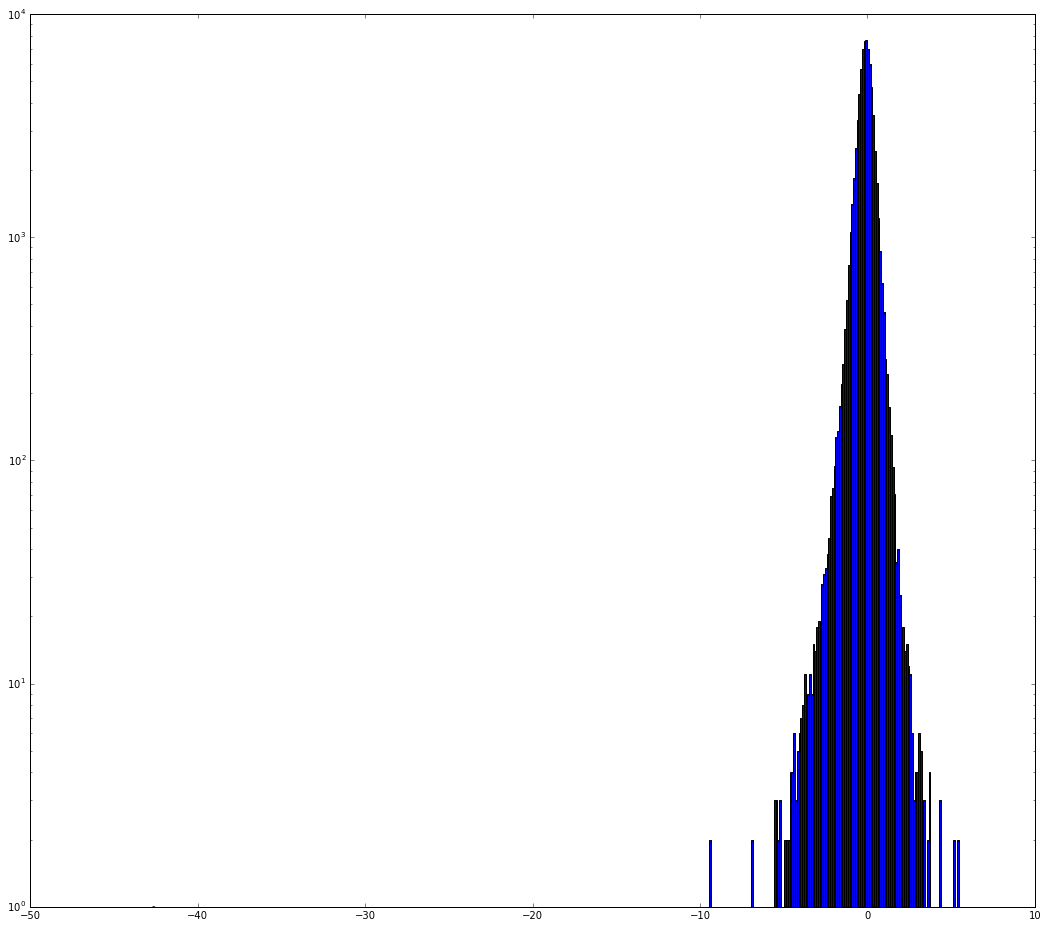

In [8]:
fig=plt.figure(figsize=(18, 16))
err_2 = err_l[np.where(np.abs(err_l) < 20.0)]
plt.hist(err_l, bins=500)
plt.gca().set_yscale("log")
plt.show()

7.44665234337


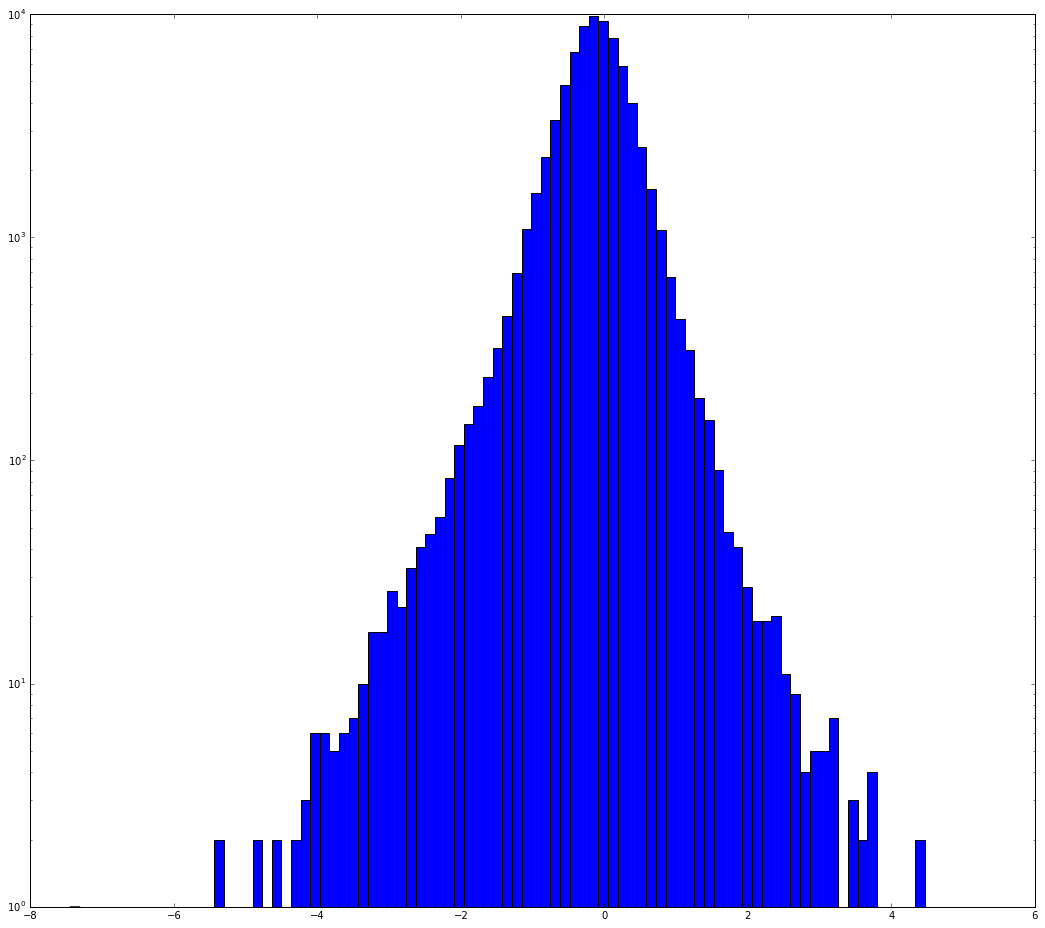

In [9]:
print(np.abs(err_c).max())
fig=plt.figure(figsize=(18, 16))
#err_2 = err_l[np.where(np.abs(err_l) < 20.0)]
plt.hist(err_c, bins=100)
plt.gca().set_yscale("log")
plt.show()

In [7]:
bi = np.where(pae > 0.15)

Nt = pae.size
Nb = bi[0].size


print(Nb,'/',Nt,' = ',Nb/float(Nt))

TypeError: unorderable types: list() > float()

In [ ]:
adl = pyt.anidataloader(file_to)
for data in adl:
    X = data['coordinates']
    S = data['species']
    Edft = hdt.hatokcal * data['energies']
    
    Eani, Fani = anicv.compute_energy_conformations(X=X,S=S)
    
    Eani = np.mean(Eani, axis=0)
    Fani = np.mean(Fani, axis=0)
    
    print(hdt.calculaterootmeansqrerror(Eani,Edft))
    